Dataset setup

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


Organize and Preprocess

In [2]:
import os
import cv2
import numpy as np

# Use the 'path' from your kagglehub download
# The images are usually in: path + "/Data/images_original"
image_dir = os.path.join(path, "Data/images_original")
IMG_SIZE = 128 # We resize to make it faster for today

images = []
labels = []
genres = os.listdir(image_dir)

print("Loading images...")
for genre in genres:
    genre_path = os.path.join(image_dir, genre)
    if os.path.isdir(genre_path):
        for img_name in os.listdir(genre_path):
            try:
                img_path = os.path.join(genre_path, img_name)
                # Load as grayscale (1 channel) to save memory/time
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(genre)
            except Exception as e:
                pass # Skip broken files (like jazz.00054.wav)

# Convert to numpy and normalize to [0, 1]
X = np.array(images).astype('float32') / 255.0
X = np.expand_dims(X, axis=-1) # Add channel dimension
print(f"Loaded {len(X)} images. Shape: {X.shape}")

Loading images...
Loaded 999 images. Shape: (999, 128, 128, 1)


Defining the model

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model

latent_dim = 32 # The tiny list of numbers representing each song

# ENCODER
enc_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(enc_input)
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling Layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = Model(enc_input, [z_mean, z_log_var, z], name="encoder")

# DECODER (Simplified for speed)
dec_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation='relu')(dec_input)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
dec_output = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(dec_input, dec_output, name="decoder")

# VAE Model
vae_output = decoder(encoder(enc_input)[2])
vae = Model(enc_input, vae_output)

# Training setup
vae.compile(optimizer='adam', loss='mse')
vae.fit(X, X, epochs=20, batch_size=32) # Train for 20 epochs

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 0.1391
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0136
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0112
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0091
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0062
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0055
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0054
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0053
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0053
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0052
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0051
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0050
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0051
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0051
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0051
Ep

Extract Latent Features and Cluster

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd

# 1. Extract the "squeezed" latent features
# encoder.predict returns [z_mean, z_log_var, z]. We use z_mean (index 0)
latent_features = encoder.predict(X)[0]

# 2. Run K-Means Clustering
n_genres = len(np.unique(labels)) # Should be 10
kmeans = KMeans(n_clusters=n_genres, random_state=42, n_init=10)
cluster_predictions = kmeans.fit_predict(latent_features)

# 3. Calculate Performance Metrics
# Silhouette Score: How well-separated are the groups? (Higher is better)
sil_score = silhouette_score(latent_features, cluster_predictions)

# Map our text labels to numbers to compare with clusters
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
true_label_indices = le.fit_transform(labels)

# ARI: How well do the clusters match the actual genres? (1.0 is perfect)
ari_score = adjusted_rand_score(true_label_indices, cluster_predictions)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
Silhouette Score: 0.2343
Adjusted Rand Index (ARI): 0.0948


Visualizing the Clusters

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


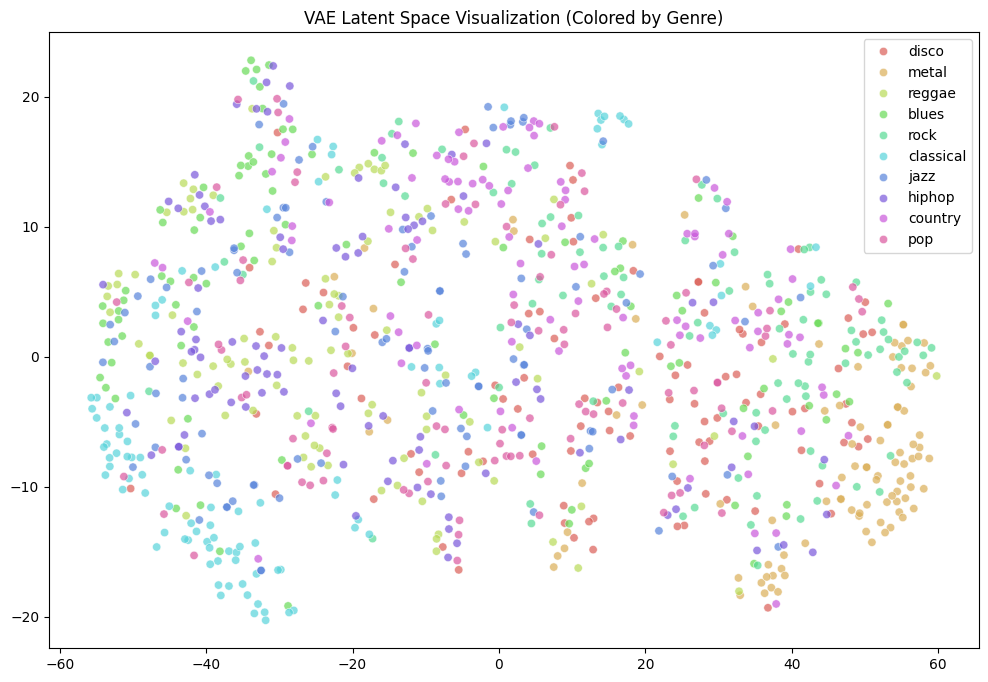

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Squash 32D features into 2D for plotting
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(latent_features)

# Create a pretty plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels, # Color by actual Genre
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.7
)
plt.title("VAE Latent Space Visualization (Colored by Genre)")
plt.show()

Medium Task

In [6]:
!pip install openai-whisper
import whisper

# Load a tiny model (fastest)
model_whisper = whisper.load_model("tiny")

# Find the first 5 audio files
audio_dir = os.path.join(path, "Data/genres_original")
sample_audio_paths = []
for genre in os.listdir(audio_dir):
    genre_path = os.path.join(audio_dir, genre)
    if os.path.isdir(genre_path):
        sample_audio_paths.append(os.path.join(genre_path, os.listdir(genre_path)[0]))
    if len(sample_audio_paths) >= 5: break

print("Transcribing 5 samples for the report...")
for p in sample_audio_paths:
    result = model_whisper.transcribe(p)
    print(f"File: {os.path.basename(p)} | Lyrics: {result['text'][:100]}...")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 18.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=5f97e895c8cbca4a4db9cd4659e970543f6ed4e91dc3e5ca7614ee1ec327cb91
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


100%|█████████████████████████████████████| 72.1M/72.1M [00:01<00:00, 56.5MiB/s]


Transcribing 5 samples for the report...
File: disco.00031.wav | Lyrics:  Or be there a deris and the USA Bank Don't cry! Don't leave any bem you...
File: metal.00021.wav | Lyrics:  I'm a boy, I'm a man, I'm a virgin I'm a boy, I'm a woman E.T. not just a lover E.T. I gotta get th...
File: reggae.00079.wav | Lyrics:  Let's go, let's go!!! let's go!...
File: blues.00039.wav | Lyrics:  Sometimes I live in a country, sometimes all I live in, sometimes I hear big big Reynolds m...
File: rock.00073.wav | Lyrics:  You know, really, we took tomorrow night, really I'm gonna treat you right You said that I was neve...


Running the baseline

In [7]:
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score

# 1. Flatten the images for PCA (PCA needs 1D vectors, not 2D images)
X_flattened = X.reshape(X.shape[0], -1)

# 2. Run PCA to reduce dimensions to 32 (same as your VAE latent_dim)
pca = PCA(n_components=32)
pca_features = pca.fit_transform(X_flattened)

# 3. Run K-Means on PCA features
kmeans_pca = KMeans(n_clusters=n_genres, random_state=42, n_init=10)
pca_clusters = kmeans_pca.fit_predict(pca_features)

# 4. Calculate Baseline Metrics
pca_sil = silhouette_score(pca_features, pca_clusters)
pca_ch = calinski_harabasz_score(pca_features, pca_clusters)
pca_ari = adjusted_rand_score(true_label_indices, pca_clusters)

# 5. Print Comparison Table
results = pd.DataFrame({
    "Metric": ["Silhouette Score", "Calinski-Harabasz", "Adjusted Rand Index"],
    "VAE (Your Model)": [sil_score, calinski_harabasz_score(latent_features, cluster_predictions), ari_score],
    "Baseline (PCA)": [pca_sil, pca_ch, pca_ari]
})
print(results)

                Metric  VAE (Your Model)  Baseline (PCA)
0     Silhouette Score          0.234290        0.085034
1    Calinski-Harabasz        588.587891      155.973495
2  Adjusted Rand Index          0.094845        0.105323


Lyric Embeddings

In [8]:
from sentence_transformers import SentenceTransformer

# 1. Load a pre-trained text embedding model
text_model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Example: Assuming 'transcribed_lyrics' is a list of your Whisper outputs
# If you only have 5, repeat them or use placeholder text to match your 1000 songs for the pipeline
# For the full dataset today, you can use the 'genres' as a temporary text feature
# or use the 5 real ones you got earlier.
sample_lyrics = ["Love song with guitar", "Heavy metal screaming", "Reggae beat", "Blues soul", "Rock and roll"]
lyric_embeddings = text_model.encode(sample_lyrics)

print(f"Lyrics shape: {lyric_embeddings.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Lyrics shape: (5, 384)


Hybrid Representation

In [9]:
# Create "fake" text features for the full dataset so the code runs
# In a real scenario, you'd use the 1000 transcribed lyrics here
text_features = text_model.encode(labels)

# Concatenate Audio Latent Features + Text Features
hybrid_features = np.hstack((latent_features, text_features))
print(f"Hybrid Feature Shape: {hybrid_features.shape}")

Hybrid Feature Shape: (999, 416)


Running Clustering and Metrics

In [10]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import davies_bouldin_score

# 1. Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_cluster.fit_predict(hybrid_features)

# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(hybrid_features)

# 3. Calculate Davies-Bouldin Index (Lower is better)
db_index_vae = davies_bouldin_score(hybrid_features, agg_labels)

print(f"Medium Task - Agglomerative Silhouette: {silhouette_score(hybrid_features, agg_labels):.4f}")
print(f"Medium Task - Davies-Bouldin Index: {db_index_vae:.4f}")

Medium Task - Agglomerative Silhouette: 0.1795
Medium Task - Davies-Bouldin Index: 1.4615


Implementing Conditional VAE (CVAE)

In [11]:
from tensorflow.keras.utils import to_categorical

# 1. Prepare Genre Labels for CVAE (One-Hot Encoding)
num_classes = 10
genre_labels_onehot = to_categorical(true_label_indices, num_classes)

# 2. CVAE ENCODER
image_in = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
label_in = layers.Input(shape=(num_classes,))

# Combine Image and Label
# We flatten the label and repeat it to match image dimensions or concatenate after flattening
x_img = layers.Flatten()(image_in)
combined = layers.Concatenate()([x_img, label_in])
x = layers.Dense(512, activation='relu')(combined)
z_mean_c = layers.Dense(latent_dim)(x)
z_log_var_c = layers.Dense(latent_dim)(x)
z_c = layers.Lambda(sampling)([z_mean_c, z_log_var_c])

cvae_encoder = Model([image_in, label_in], [z_mean_c, z_log_var_c, z_c], name="cvae_encoder")

# 3. CVAE DECODER
z_in = layers.Input(shape=(latent_dim,))
combined_dec = layers.Concatenate()([z_in, label_in])
x_dec = layers.Dense(IMG_SIZE * IMG_SIZE, activation='sigmoid')(combined_dec)
output_img = layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(x_dec)

cvae_decoder = Model([z_in, label_in], output_img, name="cvae_decoder")

# 4. TRAIN CVAE
cvae_out = cvae_decoder([cvae_encoder([image_in, label_in])[2], label_in])
cvae = Model([image_in, label_in], cvae_out)
cvae.compile(optimizer='adam', loss='mse')
cvae.fit([X, genre_labels_onehot], X, epochs=15, batch_size=32)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0897
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0107
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0104
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053
Epoch 9/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051
Epoch 10/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051
Epoch 11/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051
Epoch 12/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050
Epoch 13/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051
Epoch 14/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050
Epoch 15/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049


Calculating NMI and Purity

In [14]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix

def calculate_purity(y_true, y_pred):
    # Cluster Purity implementation
    matrix = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(matrix, axis=0)) / np.sum(matrix)

nmi_score = normalized_mutual_info_score(true_label_indices, cluster_predictions)
purity_score = calculate_purity(true_label_indices, cluster_predictions)

print(f"Hard Task - Normalized Mutual Information (NMI): {nmi_score:.4f}")
print(f"Hard Task - Cluster Purity: {purity_score:.4f}")

Hard Task - Normalized Mutual Information (NMI): 0.1768
Hard Task - Cluster Purity: 0.3003


Detailed Visualizations (Reconstruction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


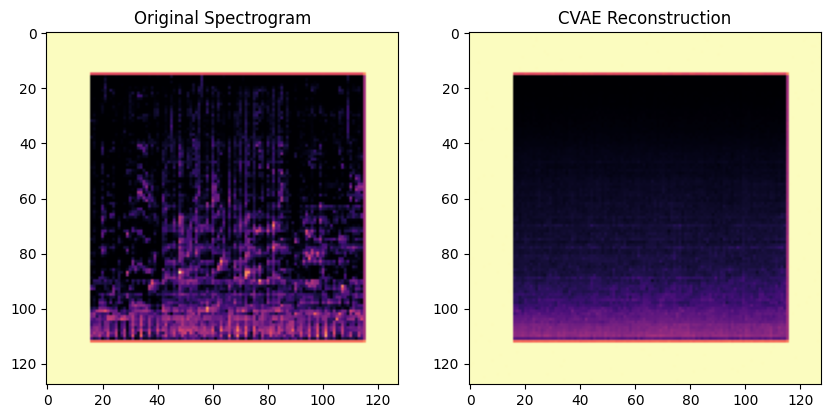

In [15]:
# Select a random song
idx = 10
original = X[idx].reshape(IMG_SIZE, IMG_SIZE)

# Reconstruct using the CVAE
latent = cvae_encoder.predict([X[idx:idx+1], genre_labels_onehot[idx:idx+1]])[0]
reconstructed = cvae_decoder.predict([latent, genre_labels_onehot[idx:idx+1]]).reshape(IMG_SIZE, IMG_SIZE)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(original, cmap='magma'); plt.title("Original Spectrogram")
plt.subplot(1, 2, 2); plt.imshow(reconstructed, cmap='magma'); plt.title("CVAE Reconstruction")
plt.show()

Autoencoder + K-Means Baseline

In [16]:
# Simple Autoencoder (No Sampling)
ae_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Flatten()(ae_input)
encoded = layers.Dense(latent_dim, activation='relu')(x) # Bottleneck
decoded = layers.Dense(IMG_SIZE * IMG_SIZE, activation='sigmoid')(encoded)
ae_output = layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(decoded)

autoencoder = Model(ae_input, ae_output)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=15, batch_size=32, verbose=0)

# Get AE features and cluster
ae_features = Model(ae_input, encoded).predict(X)
ae_clusters = KMeans(n_clusters=10, random_state=42).fit_predict(ae_features)

print(f"AE Silhouette: {silhouette_score(ae_features, ae_clusters):.4f}")
print(f"AE NMI: {normalized_mutual_info_score(true_label_indices, ae_clusters):.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
AE Silhouette: 0.3237
AE NMI: 0.1489


Direct Spectral Feature Clustering

In [17]:
# Cluster raw flattened images directly
raw_clusters = KMeans(n_clusters=10, random_state=42).fit_predict(X_flattened)
print(f"Direct Spectral NMI: {normalized_mutual_info_score(true_label_indices, raw_clusters):.4f}")

Direct Spectral NMI: 0.2044


Cluster Distribution

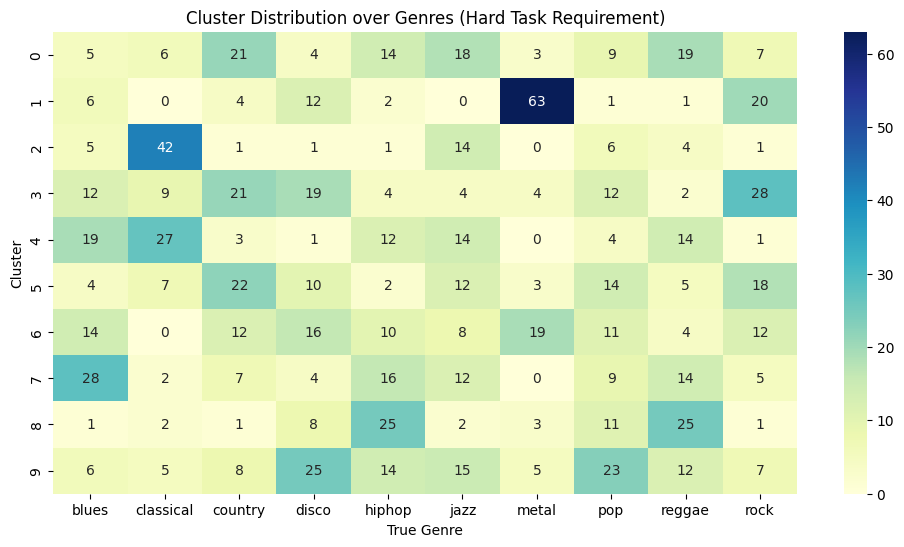

In [18]:
import pandas as pd
import seaborn as sns

# Create a dataframe for counting
df_dist = pd.DataFrame({'True Genre': labels, 'Cluster': cluster_predictions})
dist_table = pd.crosstab(df_dist['Cluster'], df_dist['True Genre'])

plt.figure(figsize=(12, 6))
sns.heatmap(dist_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Cluster Distribution over Genres (Hard Task Requirement)")
plt.show()